[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nrutachoudhari/AIPI590.01_Explainable_AI_Assignments/blob/main/HW4_Explainable_Techniques_II/AIPI%20590.01%20Assignment4.ipynb)

## AIPI 590.01 Explainable AI

### Assignment 4: Explainable Techniques II

#### Nruta Choudhari (nmc58)

#### PART 1

For a model and dataset of your choice, produce PDP, ICE, and ALE plots. Exploratory analysis of your dataset should be performed to determine the amount of correlation between features.  

 

Provide a comprehensive explanation of your plots. Discuss any interesting findings that are shown in the plots. Discuss any differences you see in the PDP and ALE plots. Discuss your exploratory findings around correlation between features and the impact this has (if any) on your results.



In [1]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /private/var/folders/56/hvtmjgr93sv24xkzrpgqbtn80000gn/T/pip-install-sk0464_5/alepython_5b6c2b6c1b9744c282094e2385fbb185
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /private/var/folders/56/hvtmjgr93sv24xkzrpgqbtn80000gn/T/pip-install-sk0464_5/alepython_5b6c2b6c1b9744c282094e2385fbb185
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done


In [2]:
# importing the necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import partial_dependence
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

/Users/nrutachoudhari/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Data Ingestion and Correlation Analysis**

The dataset I am using for this assignment is the Sleep Disorder Diagnosis Dataset from Kaggle (https://www.kaggle.com/datasets/mdsultanulislamovi/sleep-disorder-diagnosis-dataset). 

In [3]:
# importing the data
sleep_data = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv', keep_default_na=False)

sleep_data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [4]:
sleep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [5]:
# getting a count of the unique values within the target variable
print(sleep_data['Sleep Disorder'].value_counts())

Sleep Disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64


In [6]:
# dropping these columns for now. drop more later if needed
sleep_data = sleep_data.drop(columns=['Person ID'])

In [7]:
target_column = 'Sleep Disorder'
target_names = sleep_data[target_column].unique().tolist()

# separating features and target variable
y = sleep_data[target_column]
X = sleep_data.drop(columns=[target_column], axis = 1, errors = 'ignore')

In [8]:
# handling categorical variables by encoding them
cat_cols = X.select_dtypes(include=['object']).columns
print(f'Categorical columns: {cat_cols.tolist()}')

Categorical columns: ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure']


In [9]:
# encoding categorical variables
label_encoders = {}
X_processed = X.copy()

for col in cat_cols:
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
label_encoders['target'] = le_target

feature_names = X_processed.columns.tolist()

Encoded Gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Encoded Occupation: {'Accountant': np.int64(0), 'Doctor': np.int64(1), 'Engineer': np.int64(2), 'Lawyer': np.int64(3), 'Manager': np.int64(4), 'Nurse': np.int64(5), 'Sales Representative': np.int64(6), 'Salesperson': np.int64(7), 'Scientist': np.int64(8), 'Software Engineer': np.int64(9), 'Teacher': np.int64(10)}
Encoded BMI Category: {'Normal': np.int64(0), 'Normal Weight': np.int64(1), 'Obese': np.int64(2), 'Overweight': np.int64(3)}
Encoded Blood Pressure: {'115/75': np.int64(0), '115/78': np.int64(1), '117/76': np.int64(2), '118/75': np.int64(3), '118/76': np.int64(4), '119/77': np.int64(5), '120/80': np.int64(6), '121/79': np.int64(7), '122/80': np.int64(8), '125/80': np.int64(9), '125/82': np.int64(10), '126/83': np.int64(11), '128/84': np.int64(12), '128/85': np.int64(13), '129/84': np.int64(14), '130/85': np.int64(15), '130/86': np.int64(16), '131/86': np.int64(17), '132/87': np.int64(18), '135/88': np.int64(19), '135

In [10]:
# cross-checking if all columns have been successfully encoded as numeric
X_processed.dtypes

Gender                       int64
Age                          int64
Occupation                   int64
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                 int64
Blood Pressure               int64
Heart Rate                   int64
Daily Steps                  int64
dtype: object

> All the columns are numeric, so moving on

In [11]:
# encoding the target variable as it is multi-class
le_target = LabelEncoder()
y = le_target.fit_transform(y)
label_encoders['target'] = le_target

> Conducting correlation analysis now to see how the features are correlated to one another

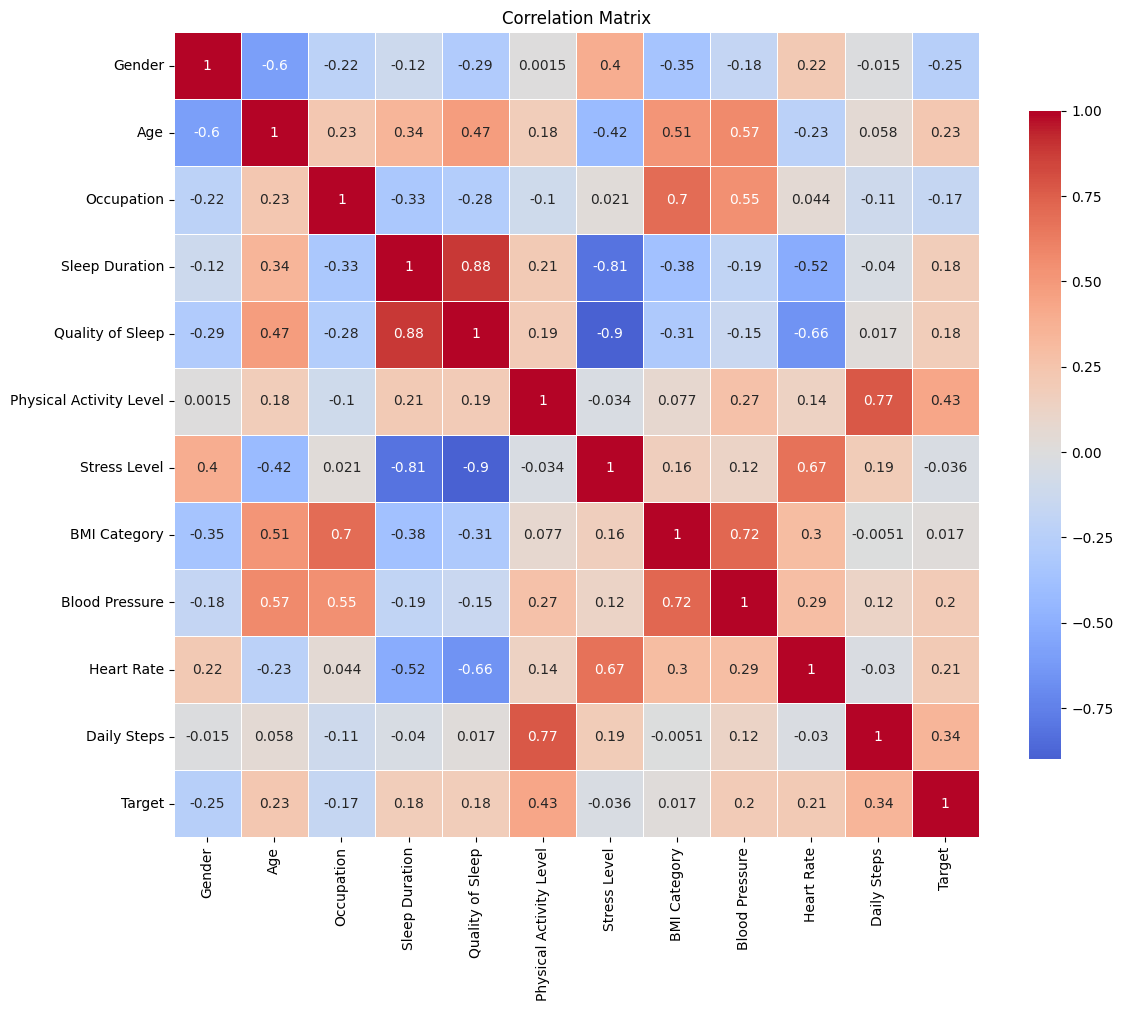

In [12]:
# creating a correlation matrix 
X_with_target = X_processed.copy()
X_with_target['Target'] = y

corr_matrix = X_with_target.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

> From the correlation matrix, we can see the following:
> * There is a high positive correlation between Sleep Duration and Quality of Sleep (0.88) which checks out as sleeping for longer allows the brain to complete full sleep cycles.
> * There is a high positive correlation between Physical Activity Level and Daily Steps (0.77). This makes sense as the number of steps taken by an individual count towards activity and exercise.
> * Blood Pressure and BMI Cateogry have a high positive correlation of 0.72, which could be explained by higher BMIs having increased risk of cardiovascular conditions.
> * There is a high positive correlation between BMI and Occupation (0.7) which could be because of a majority of them are desk jobs which lead to people leading more sedentry lifestyles, and this is further indicated by the correlation of BMI with Physical Activity Level which is very low (0.077).
> * Additionally, there is a high negative correlation between Stress Level and Sleep Duration (-0.81) and Stress Level and Quality of Sleep (-0.9), as good sleep reduces stress levels and allows the body to rest.

### **Data Modeling with Random Forest**

Using a Random Forest Classifier for this data to see how well attributes are at predicting whether a person has a sleep disorder or not.

In [13]:
# spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

# checking the shape of the training and testing sets
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

Training set shape: (299, 11), Testing set shape: (75, 11)


In [14]:
# training the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, max_depth = 10, random_state=42, n_jobs=1)

model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
# making predictions
y_pred = model.predict(X_test)

In [16]:
# evlaluating the model and pasting the evaluation metrics
print(f"Accuracy of the model: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy of the model: 0.9600

Classification Report:
              precision    recall  f1-score   support

        None       0.88      0.93      0.90        15
 Sleep Apnea       1.00      0.98      0.99        44
    Insomnia       0.94      0.94      0.94        16

    accuracy                           0.96        75
   macro avg       0.94      0.95      0.94        75
weighted avg       0.96      0.96      0.96        75



In [17]:
"""
The following code was taken from Dr. Bent's example workbook on Github
"""

# compute permutation importances
perm_imp = permutation_importance(model, X_test, y_test,
                           n_repeats=30,
                           random_state=0)
     

# print the mean and standard deviation of permutation importances for each feature

for i in perm_imp.importances_mean.argsort()[::-1]:
    if perm_imp.importances_mean[i] - 2 * perm_imp.importances_std[i] > 0:
        print(f"{X.columns[i]:<8} "
              f"{perm_imp.importances_mean[i]:.3f}"
              f" +/- {perm_imp.importances_std[i]:.3f}")

Blood Pressure 0.050 +/- 0.022
Sleep Duration 0.044 +/- 0.016


> Using Permutation Feature Importance, we can see that these two features are reliably important and not just random noise.

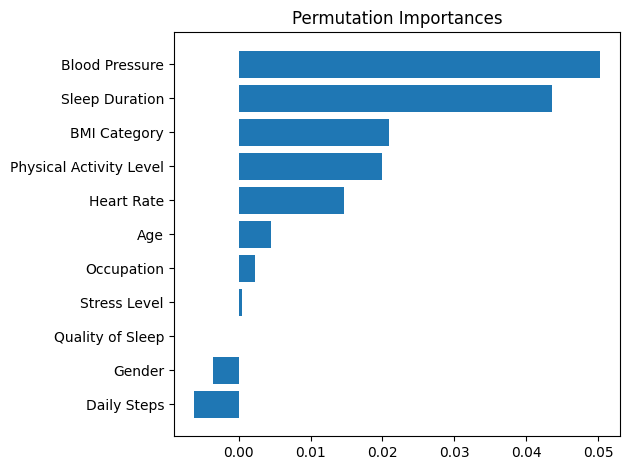

In [18]:
# plot permutation feature importances as a bar chart

sorted_idx = perm_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_test.columns[sorted_idx], perm_imp.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

> Except for Gender, Daily Steps (which were negative) and Quality of Sleep (which was zero), all the features have a positive mean importance value. However, out of these only Blood Pressure and Sleep Duration passed the statistical significance threshold, which indicates that their importance is not due to random variation.
>
> Gender and Daily Steps have a negative mean importance value which means that these variables actually positively impact the model. But here, these variables do not pass the statistical significance threshold and are thus excluded.

In [19]:
# creating a list of the top 2 features based on permutation importance
features = ['Blood Pressure', 'Sleep Duration']

> Now, we will move onto Global Explanations. As the target variable in the dataset has multiple classes, I have created a plot for each class to understand how the features influence certain decisions.

### **Partial Dependence Plot (PDP)**

Analyzing class: Insomnia


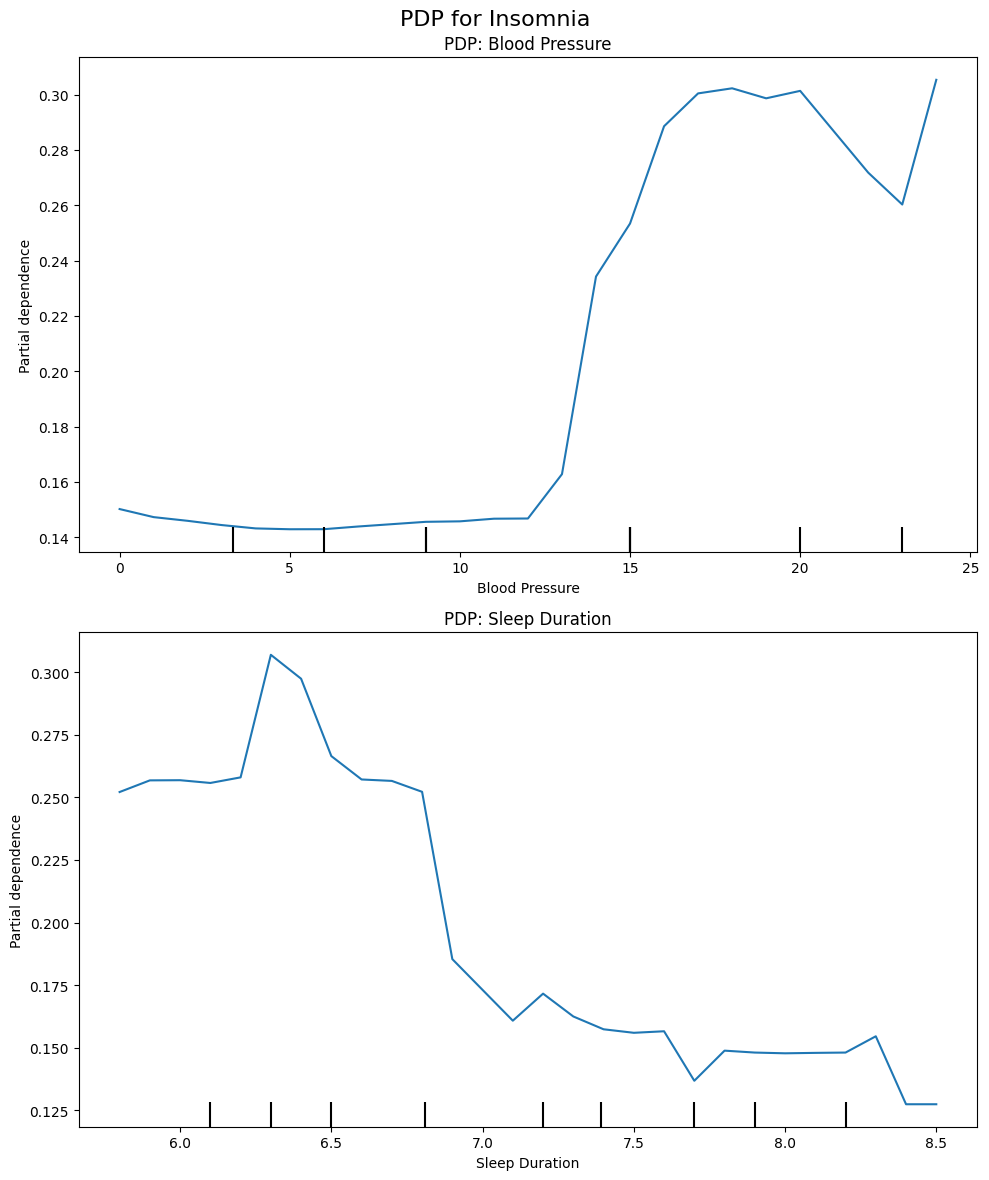

Analyzing class: None


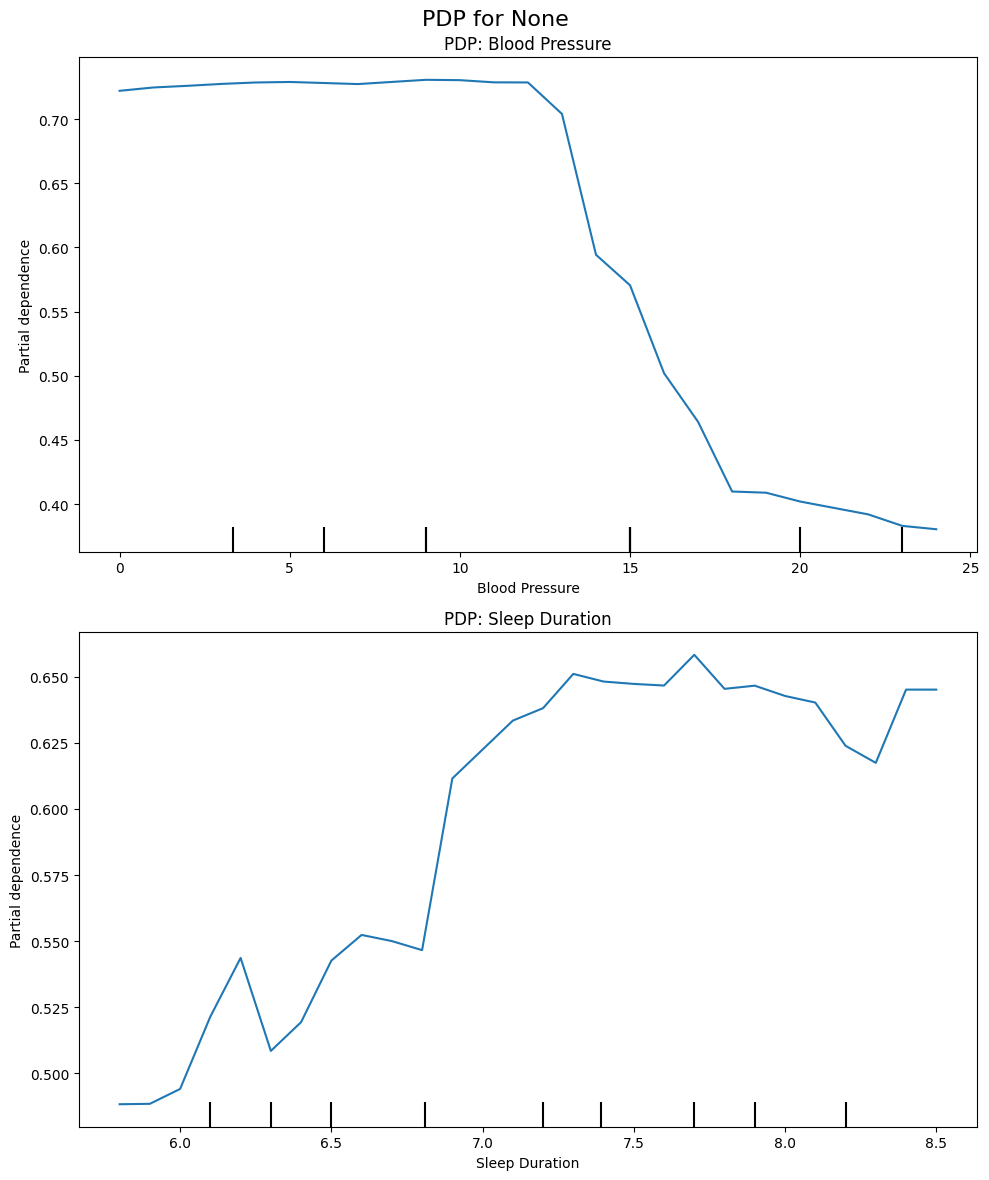

Analyzing class: Sleep Apnea


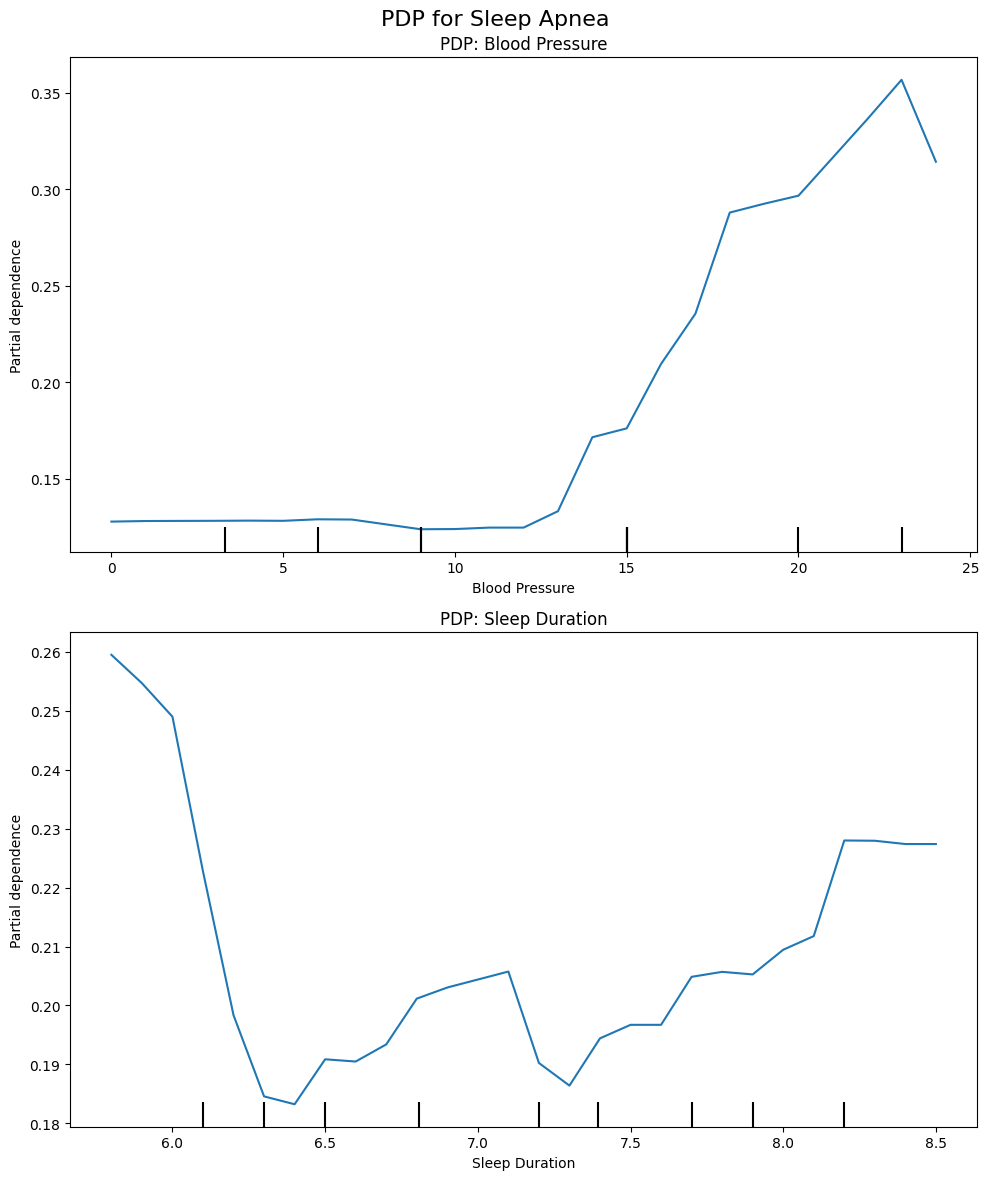

In [20]:
"""
The following code was taken from Dr. Bent's example workbook on Github
"""

# analyzing each class separately
for target_class in range(len(le_target.classes_)):
    print(f"Analyzing class: {le_target.classes_[target_class]}")
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    
    for i, feature in enumerate(features):
        PartialDependenceDisplay.from_estimator(
            model, X_train, [feature], 
            target=target_class, kind='average', ax=axes[i]
        )
        axes[i].set_title(f'PDP: {feature}')
    
    plt.suptitle(f'PDP for {le_target.classes_[target_class]}', fontsize=16)
    plt.tight_layout()
    plt.show()

> **Blood Pressure PDPs**
> 1. Insomnia:
> The shape of the curve is non-linear and upward sloping, showing that as the blood pressure increases from 12 to 20, the probability of insomnia rises sharply. Beyond a blood pressure of 18, further increases have minimal additional effect. Higher blood pressure is associated with stress, anxiety, which can all contribute to insomnia.
>
> 2. Sleep Apnea: 
> The shape of the curve is non-linear and upward sloping, almost monotonic in nature. As blood pressure increases from 12 to 23, the probablity of having sleep apnea increases drastically. This is highly intuitive as sleep apnea can lead to breathing problems which can contribute to high blood pressure.
>
> 3. None:
> The shape is non-linear and downward sloping. As the blood pressure increases above 12, the probability of no disorder decreases sharply. This is the complete opposite of the above two cases and confirms that blood pressure is a strong indicator of sleep health and sleep disorders.
>
> **Sleep Duration PDPs**
> 1. Insomnia:
> The shape of the curve is non-linear with a sharp peak followed by a steep decline. Insomnia is characterized with a reduced sleep duration, which is indicated in the plot.
> 2. Sleep Apnea:
> The shape of the curve is somewhat U-shaped with a slight increase at higher durations. This is complex as sleep apnea patients may show varied sleep times and the plot shows both extremes can be associated with it.
> 3. None:
> The shape of the plot is non-linear with a gradual upward curve. The model has correctly learnt that higher sleep durations are linked to no sleep disorders.

### **INDIVIDUAL CONDITIONAL EXPECTATION (ICE) PLOTS**

Analyzing class: Insomnia


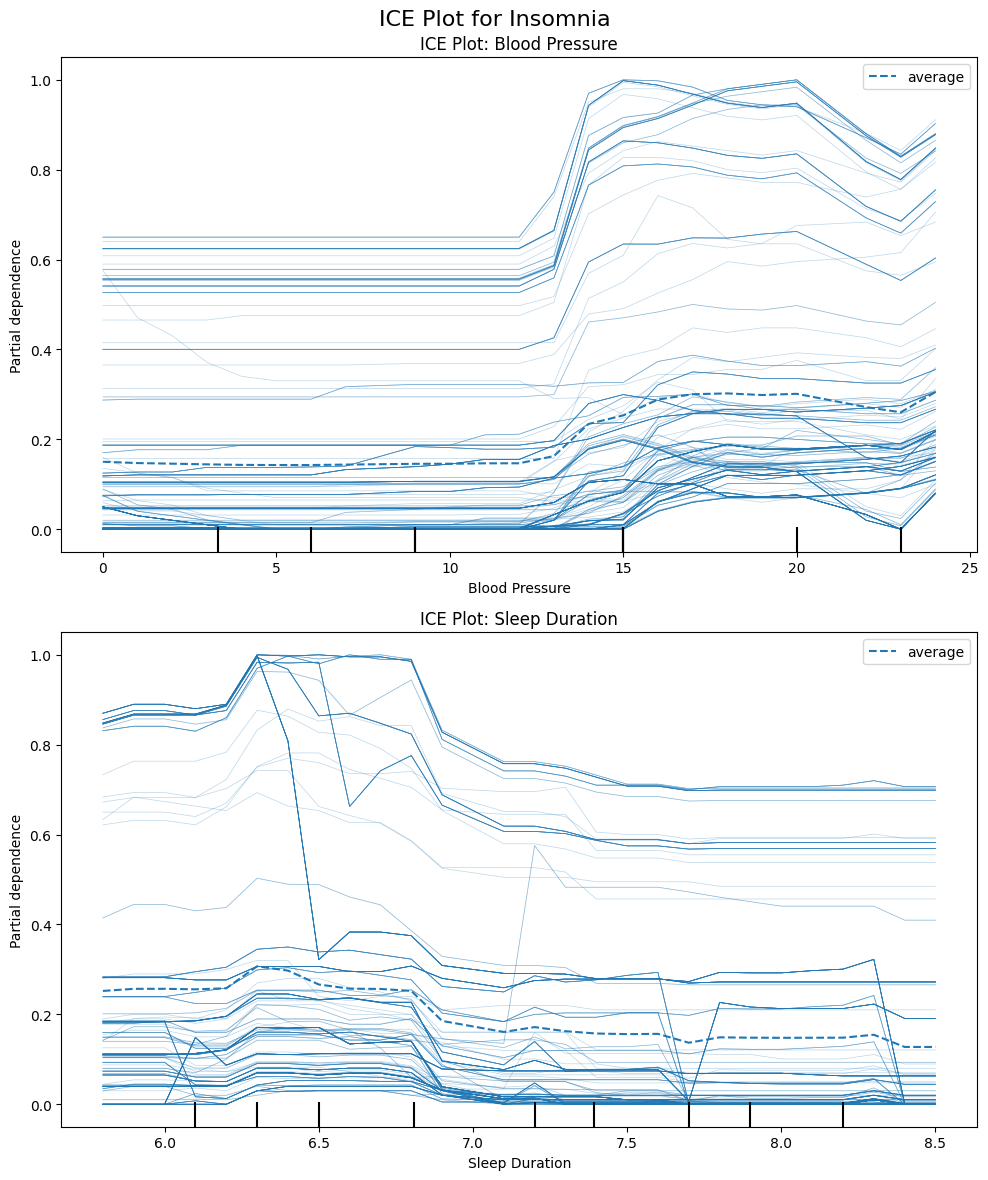

Analyzing class: None


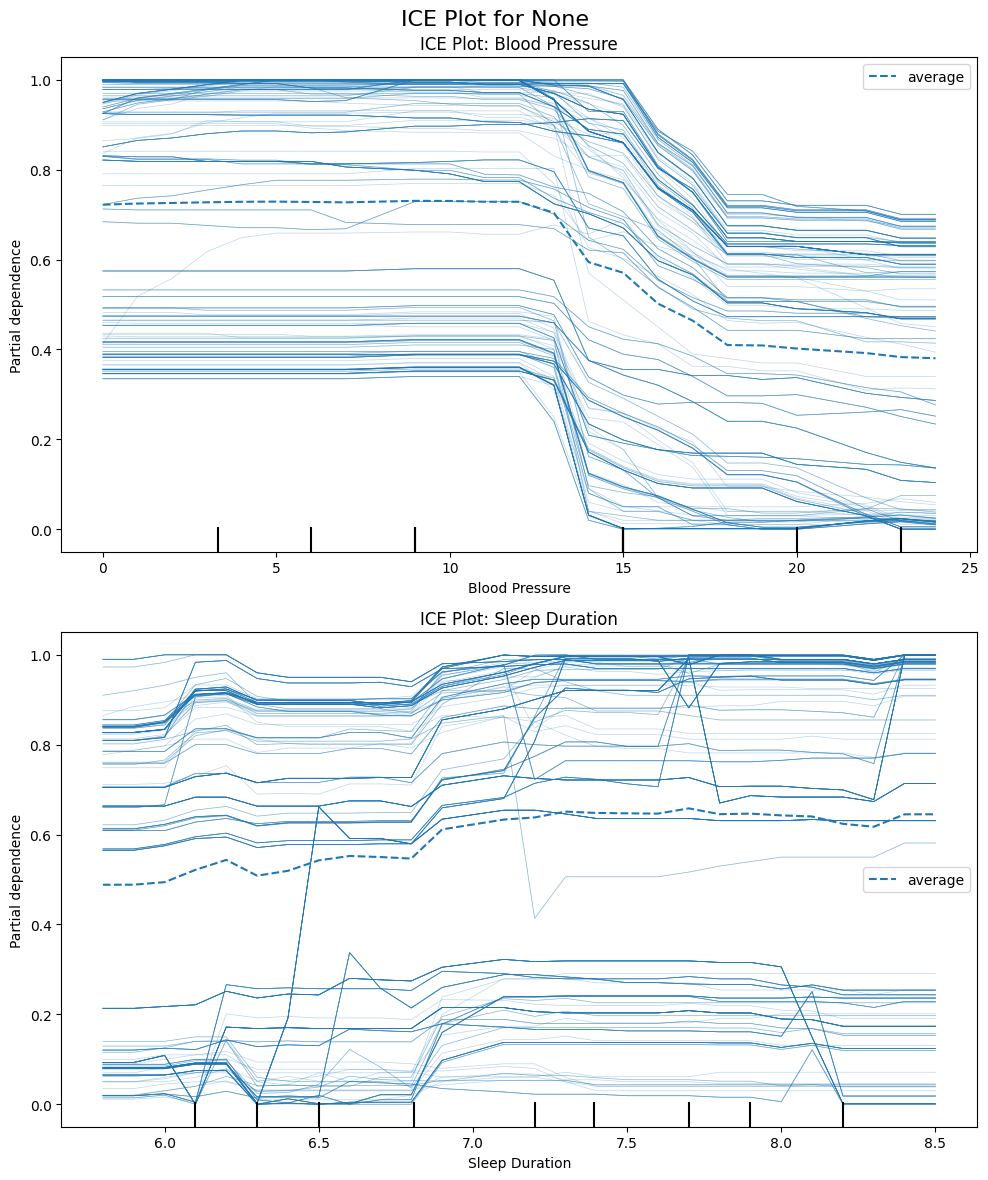

Analyzing class: Sleep Apnea


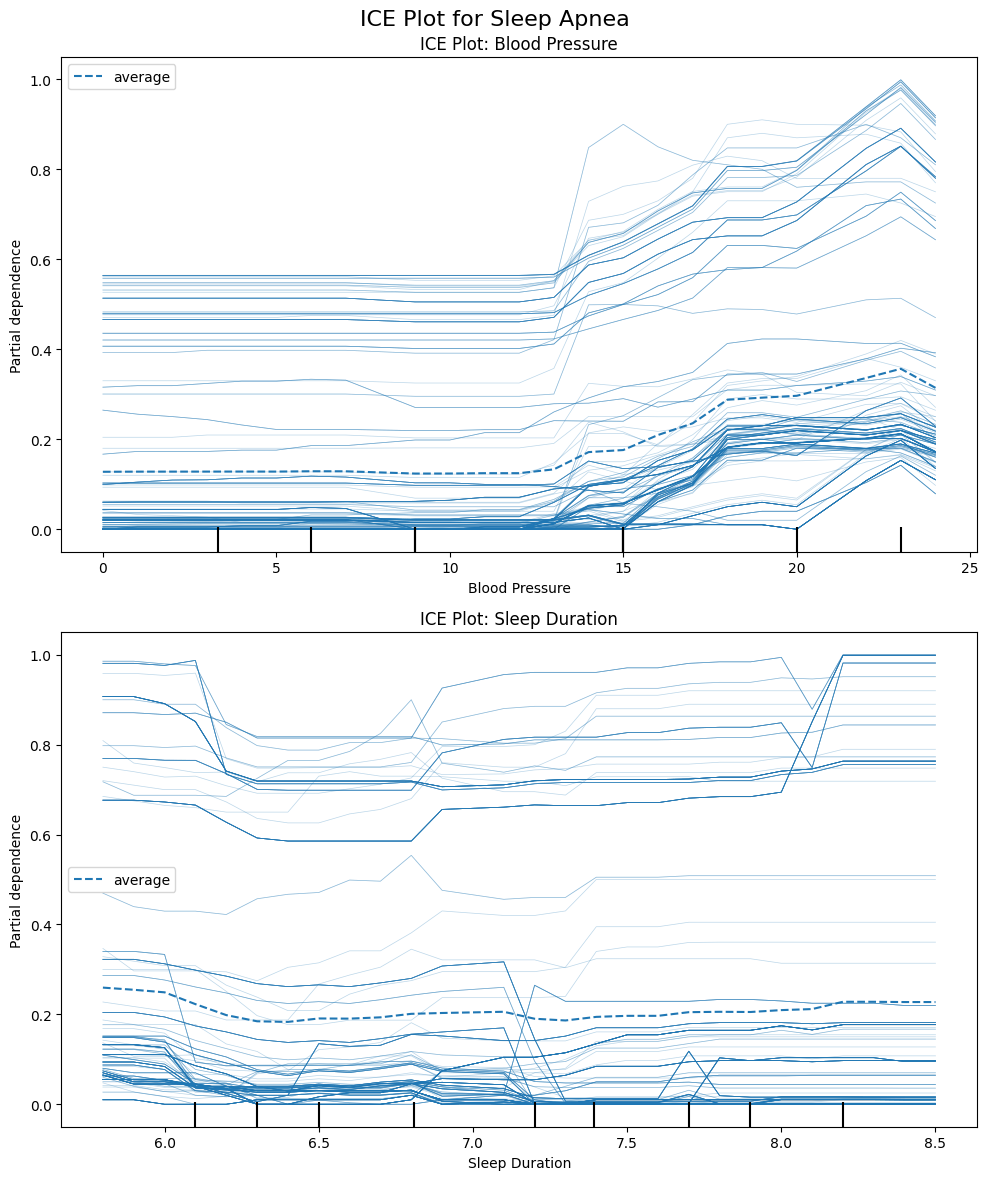

In [21]:
"""
The following code was taken from Dr. Bent's example workbook on Github
"""

# analyzing each class separately
for target_class in range(len(le_target.classes_)):
    print(f"Analyzing class: {le_target.classes_[target_class]}")
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    
    for i, feature in enumerate(features):
        PartialDependenceDisplay.from_estimator(
            model, X_train, [feature], 
            target=target_class, kind='both', ax=axes[i]
        )
        axes[i].set_title(f'ICE Plot: {feature}')
    
    plt.suptitle(f'ICE Plot for {le_target.classes_[target_class]}', fontsize=16)
    plt.tight_layout()
    plt.show()

> **Blood Pressure ICE Plots**
> 1. Insomnia:
> Most of the ICE curves are relatively flat at low BP and then show a sharp upward jump. The individual lines fan out at higher BP values. The direction is predominantly upward sloping for more individuals once the BP exceeds 12. The ICE lines reveal that the PDP hides individual variability. 
> 2. Sleep Apnea:
> The linear are flat at low BP and then most lines surge upward around BP 13-20. The spread is even wider than that for Insomnia and the trend is upward for a majority of individuals. 
> 3. None:
> The lines start at various high levels but then almost all the lines decline sharply and convergence around BP 12-18. There is much less heterogeneity when compared to disorder classes as there is a downward trend as BP increases. Here, the PDP line too accurately represents most individual paths.
>
> **Sleep Duration ICE Plots**
> 1. Insomnia:
> The ICE curves show different patterns across individuals where some lines show sharp peaks and then drop dramatically while others remain flat throughout. These lines show that individual cases might vary dramatically.
> 2. Sleep Apnea:
> The ICE curves show a clearer pattern than they did for Insomnia but there's still some variation. Many of the lines are relatively flat or show slightly declining trends. Sleep duration has inconsistent effects on sleep apnea predictions.
> 3. None:
> The lines here show a clear divide, with them being either near 0 or 1. There is a general upward trend around 6.5-7.5 hours for many individuals. The PDP line masks this divide. 

### **ALE PLOTS**

Analyzing class: Insomnia


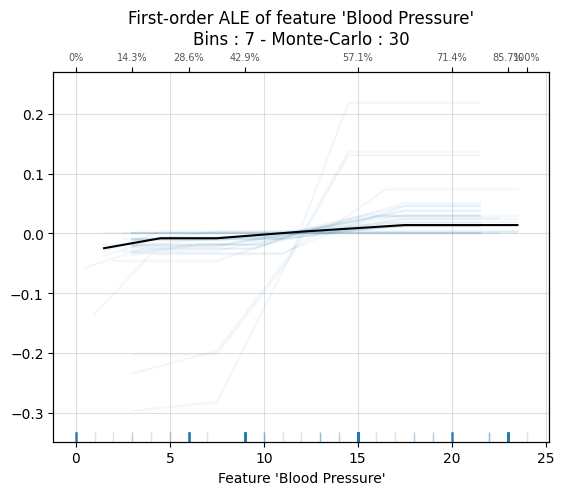

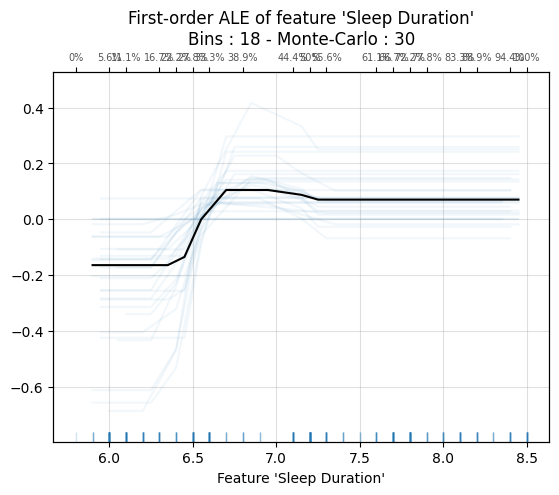

Analyzing class: None


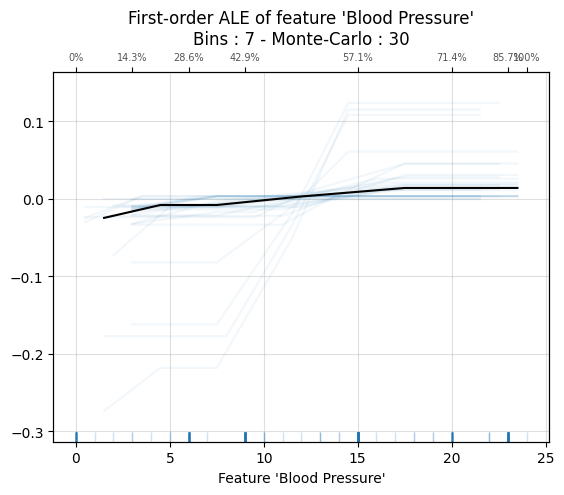

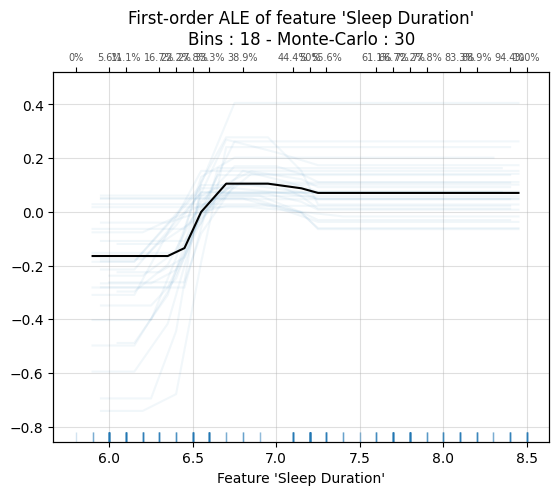

Analyzing class: Sleep Apnea


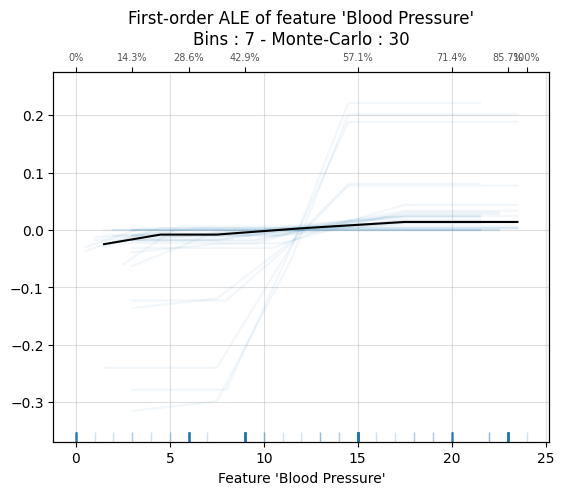

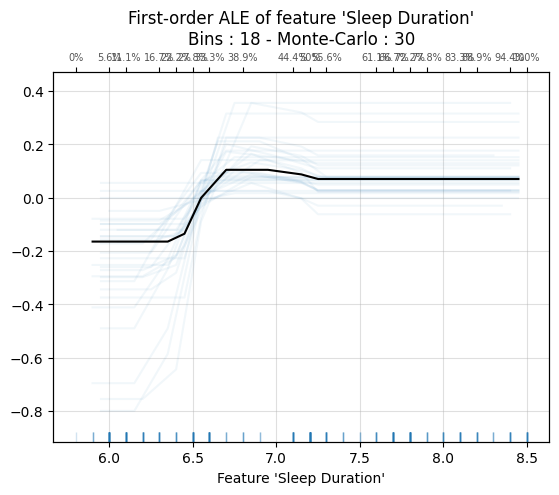

In [22]:
"""
The following code was taken from Dr. Bent's example workbook on Github
"""

# analyzing each class separately
for target_class in range(len(le_target.classes_)):
    print(f"Analyzing class: {le_target.classes_[target_class]}")
    
    for i, feature in enumerate(features):
         ale_plot(model, X_train, feature, bins=20, monte_carlo=True, monte_carlo_rep=30, monte_carlo_ratio=0.5)
   

> **Blood Pressure ALE Plots**
> 1. Insomnia:
> The shape is nearly flat, almost linear with a very slight upward trend. The direction is horizontal with minimal positive slope. Blood pessure has almost no independent local effect on prediction of insomnia after accounting for correlation with other features. This is different from PDP which showed an upward curve.
> 2. None:
> There is a slight upward curve. There is a slight negative effect at low BP but it transitions to slightly positive at a higher BP. Thus, BP has a weak independent effect on predicting no disorder.
> 3. Sleep Apnea:
> The curve is almost horizontal and there is no consistent direction. Thus, blood pressure has virtually no independent local effect on sleep apnea. This too contrasts the PDP curve.
>
> **Sleep Duration ALE Plots**
> 1. Insomnia:
> The shape is a sharp increase and then almost flat. Sleep duratio has a real independent effect on insomnia and a shorter duration increases risk. There is a threshold effect around 6.5 hours.
> 2. None:
> The shape of the curve is similar to that of insomnia, again suggesting that a longer sleep duration has an independent effect against disorders. The pattern confirms that sleep duration matters beyond correlations.
> 3. Sleep Apnea:
> There is a stong negative effect at short durations and then a slightly positive effect at longer durations. Thus, sleep duration has a moderate independent effect on sleep apnea.

Creating 2D plot for class: Insomnia


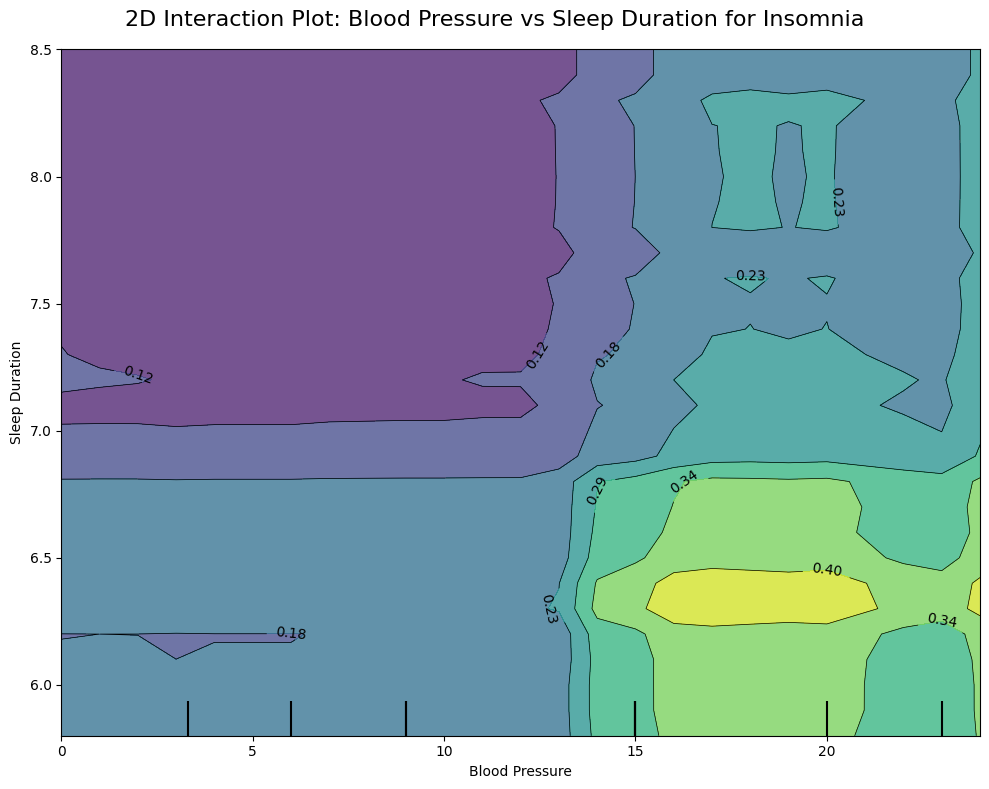

Creating 2D plot for class: None


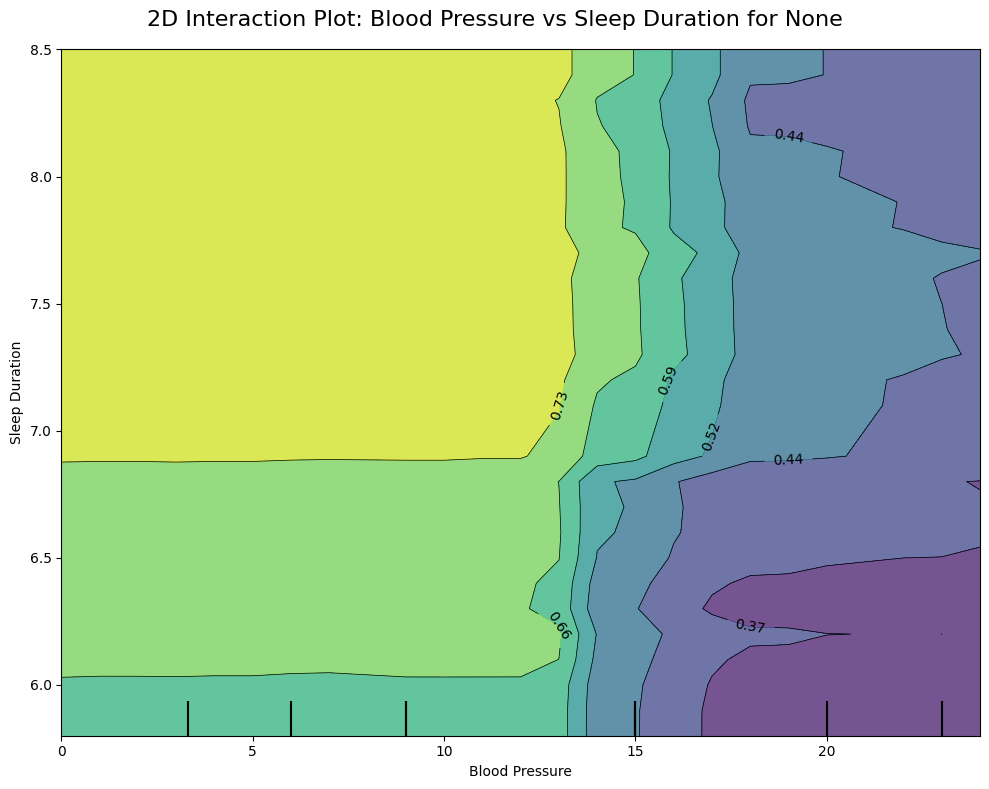

Creating 2D plot for class: Sleep Apnea


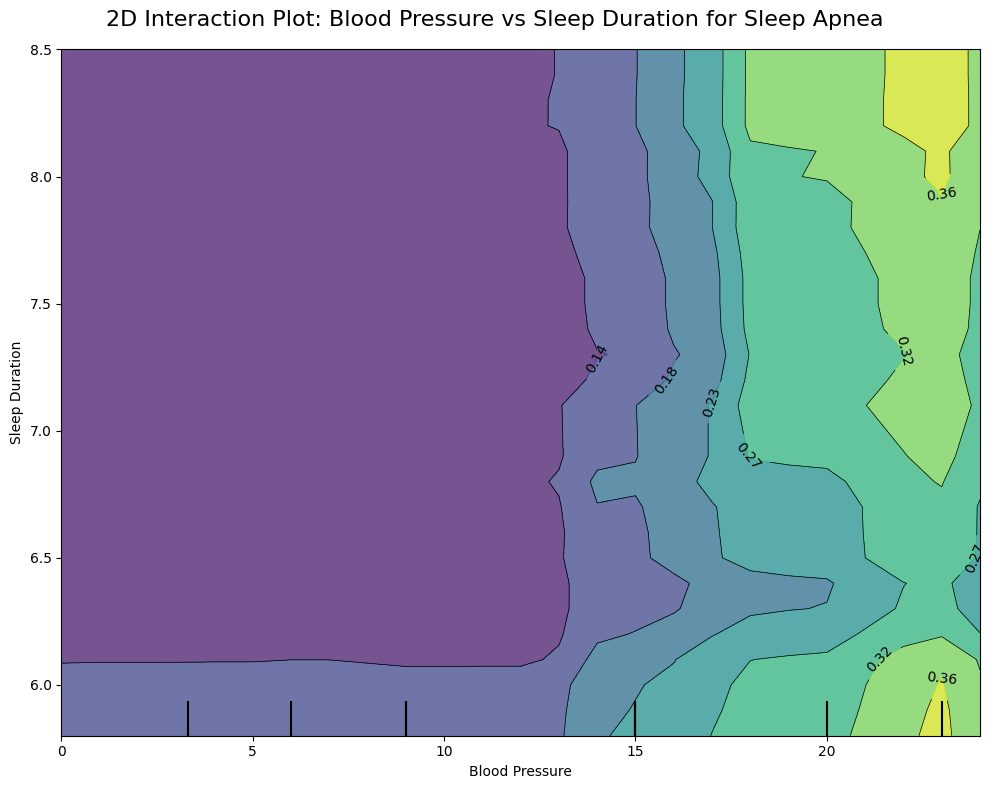

In [23]:
"""
The following code was generated with the help of Claude Sonnet 4.0. I was getting an error when using the code from the example notebook for 2D ALE plots.

The prompt fed into it was the following error message:
---------------------------------------------------------------------------
NotImplementedError                       Traceback (most recent call last)
Cell In[26], line 1
----> 1 ale_plot(model, X_train, ['Sleep Duration', 'Blood Pressure'], bins=10)

File ~/miniforge3/lib/python3.12/site-packages/alepython/ale.py:767, in ale_plot(model, train_set, features, bins, monte_carlo, predictor, features_classes, monte_carlo_rep, monte_carlo_ratio, rugplot_lim)
    759 if features_classes is None:
    760     # Continuous data.
    761     ale, quantiles_list = _second_order_ale_quant(
    762         model.predict if predictor is None else predictor,
    763         train_set,
    764         features,
    765         bins,
    766     )
--> 767     _second_order_quant_plot(fig, ax, quantiles_list, ale)
    768     _ax_labels(
    769         ax,
    770         "Feature '{}'".format(features[0]),
    771         "Feature '{}'".format(features[1]),
    772     )
    773     for twin, quantiles in zip(("x", "y"), quantiles_list):

File ~/miniforge3/lib/python3.12/site-packages/alepython/ale.py:267, in _second_order_quant_plot(fig, ax, quantiles_list, ale, mark_empty, n_interp, **kwargs)
    264 y = np.linspace(centres_list[1][0], centres_list[1][-1], n_y)
    266 X, Y = np.meshgrid(x, y, indexing="xy")
...
`CloughTocher2DInterpolator`.

For more details see
https://scipy.github.io/devdocs/tutorial/interpolate/interp_transition_guide.html

However, I have further modified the code myself to give a 2D ALE plot for all target classes.
"""

# extracting the feature indices
feature_idx1 = X_train.columns.get_loc(features[0])
feature_idx2 = X_train.columns.get_loc(features[1])

# creating the 2D interaction plot
for target_class in range(len(le_target.classes_)):
    print(f"Creating 2D plot for class: {le_target.classes_[target_class]}")
    fig, ax = plt.subplots(figsize=(10, 8))
    PartialDependenceDisplay.from_estimator(
        model, 
        X_train, 
        [(feature_idx1, feature_idx2)], 
        target=target_class,  
        kind='average',
        ax=ax
    )
    plt.suptitle(f'2D Interaction Plot: {features[0]} vs {features[1]} for {le_target.classes_[target_class]}', fontsize=16)
    plt.tight_layout()
    plt.show()

> 1. Insomnia:
> A shorter sleep duration and a moderate to higher BP is the right combination for the risk of insomnia. Low BP regardles of sleep durations and long sleep durations with low to moderate BP indicate a low risk of insomnia. High BP alone doesn't automatically increase risk.
> 2. None:
> The features work together, suggesting that an individual needs both higher sleep duration and low BP to have a higher chance of no sleep disorder. One feature in a healthy range alone is not sufficient.
> 3. Sleep Apnea:
> There is a high risk of sleep apnea if the BP is high and is particularly pronounced at very short or very long sleep durations. BP is the primary influencer for the prediction of sleep apnea.

> **Comparison**
> * The PDP plots showed that Blood Pressure had strong effects across all classes. However, ALE plots revealed that the true effects are due to correlation with other features. This aligns with the correlation matrix above, where blood pressure has moderate to high correlation with other features. 
> * Both PDP and ALE plots show that sleep duration has actual effects on predictions, particularly for insomnia and none classes. 
> * The 2D interaction plots help clarify the relationships between the features. For insomnia cases, both of the features contribute but their joint effects matter the most. For sleep apnea, blood pressure mattered most and for an individual to have no sleep disorder they have to have good sleep and low BP.